In [2]:
%matplotlib inline

import sys
import os
sys.path.append("../../..")

import numpy as np
import re
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from sklearn.model_selection import KFold
from PIL import Image
import xml.etree.ElementTree as ET

from osgeo import gdal
import osr
import my_packages.My_Geoprocess as mgp

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score


## Get Rasters Informations, size, Geotransform... following one of the grid

In [3]:
ClassifFolder = '../../../Poe/Resultats/Classifications/'
ImagesFolder = '../../../Poe/Images/Acolyte/S2A_MSIL1C_20180305T230901_N0206_R101_T58KEB_20180306T00234_bisAco/S2A_MSI_2018_03_05_23_09_01_T58KEB_L2R_tif/'
raster_wavelength = ['560']
raster_Name = ['rhos_' + l + '.tif' for l in raster_wavelength]

src_ds = gdal.Open(ImagesFolder+raster_Name[0], gdal.GA_ReadOnly)
band = src_ds.GetRasterBand(1)
GT_ds = src_ds.GetGeoTransform()
proj = src_ds.GetProjection()
RasterHeight, RasterWidth = (src_ds.RasterYSize, src_ds.RasterXSize)
print(RasterHeight, RasterWidth)

AttributeError: 'NoneType' object has no attribute 'GetRasterBand'

## Define Rasters footprint

In [11]:
# Define Raster Footprint
min_x = GT_ds[0]
min_y = GT_ds[3] + RasterWidth*GT_ds[4] + RasterHeight*GT_ds[5] 
max_x = GT_ds[0] + RasterWidth*GT_ds[1] + RasterHeight*GT_ds[2]
max_y = GT_ds[3]   

srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, min_N), '\nLower right corner : ', (max_E, max_N))


Upper left corner :  (164.99980652185837, -21.791778063706154) 
Lower right corner :  (166.0548316017674, -20.79645641405817)


## Get surveyfiles (ascii), having measurement contained in rasters footprint

In [12]:
FileWorkableSur = '../../Terrain/MesuresBathy/Poe_22and23_05_2018.txt'

MeasurementFrame = pd.read_csv(FileWorkableSur)
Lon = MeasurementFrame['Lon'].astype('float64').values
Lat = MeasurementFrame['Lat'].astype('float64').values

CoordinatesSet = np.stack([Lon,Lat], axis=1)
depth = MeasurementFrame['Depth'].astype('float32').values

del MeasurementFrame, Lon, Lat

##  Convert measurements coordinate in pixels coordinate (+ checking process)

In [13]:
testLocation = np.array([[166.0618842, -21.7883184],
                         [166.0618359, -21.7882778],
                         [166.0619313, -21.7882778],
                         [166.0619313, -21.7883652],
                         [166.0618326, -21.7883166]])

# Define pixel location of measured data
ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)
(Cols, Rows) = mgp.GetPixel(ctInv, inv_geometrix, testLocation,integer=False)
Location = ['Center', 'UpperLeft', 'UpperRight', 'LowerRight','PreviousNext']
[print(Loc,'at Row:', row,', Col:', col) for Loc, col, row in zip(Location, Cols,Rows)]

# Project coordinates in pixel coordinates then filter measured data projected outside image extent
px, py = mgp.GetPixel(ctInv, inv_geometrix, CoordinatesSet,integer=False) # Case for dense field data, need interger=False for wheigtering or interpolation
indexOut = np.logical_or(np.logical_or(py>RasterHeight-1,py<0), np.logical_or(px>RasterWidth-1,px<0))
px, py = px[~indexOut], py[~indexOut]

# Adjust water depth following the Tide at the image sensor Time
TideHeight = 1.31 # Height of tide from SHOM website
depth = depth[~indexOut]+TideHeight

# filter measured data with negative depth (due to tide)
indexOut = depth<0
print('Number of point with negative depth :', np.sum(indexOut))
px, py, depth = px[~indexOut], py[~indexOut], depth[~indexOut]
assert px.shape==py.shape and px.shape == depth.shape

no int
Center at Row: 10979.4685216 , Col: 10979.5091234
UpperLeft at Row: 10979.0156563 , Col: 10979.0128596
UpperRight at Row: 10979.0224421 , Col: 10979.999165
LowerRight at Row: 10979.9899339 , Col: 10979.9925083
PreviousNext at Row: 10979.444926 , Col: 10978.9757872
no int
Number of point with negative depth : 0


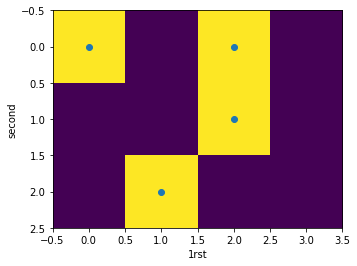

In [14]:
A = np.array([[True,False,True, False],
             [False,False,True, False],
             [False,True,False, False]])
fig, ax = plt.subplots()
row, col = np.where(A)
ax.imshow(A)
ax.scatter(col, row)
ax.set_xlabel('1rst')
ax.set_ylabel('second')

In [15]:
import shapely

In [ ]:
shapely.

<function matplotlib.pyplot.show>

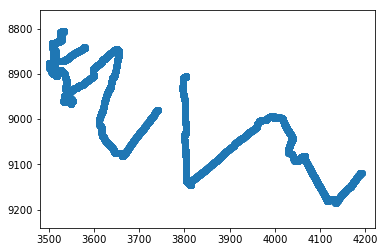

In [92]:
plt.imshow(A)
plt.scatter(px,py)
plt.axis('equal')
plt.ylim(9200, 8800)
plt.xlim(3480, 4220)
plt.show

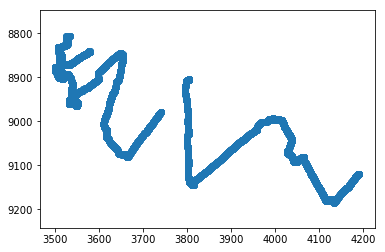

In [87]:
fig, ax = plt.subplots()
ax.invert_yaxis()
plt.axis('equal')
ax.scatter(px,py)


## Get workingIndex or Index of classification and bathymetry mapping
###### In others words :        ClassifIndex = ~Soil x ~DeepOcean x CroppedImage
######                                     ClassifIndex.shape == Initial_Rasters.shape

(10980, 10980)


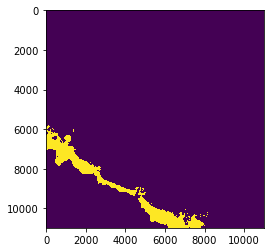

In [16]:
Lagoon = 'Mask/Lagoon.tif'

ClassifIndex = gdal.Open(ImagesFolder + Lagoon, gdal.GA_ReadOnly)
ClassifIndex = ClassifIndex.GetRasterBand(1).ReadAsArray().astype(bool)
print(ClassifIndex.shape)
plt.imshow(ClassifIndex)

## Create index(SurveyIndex) indicating the presence of measurements in a pixel
## Create dictionary(Dicto) of depths measured at a pixel location

In [17]:
# Create sub (2d) index for measured pixel
SurveyIndex = np.full(ClassifIndex.shape, 0, dtype=np.int8)
DictoDeph = {}
DictoPos = {}
for i in range(len(px)):
    Intpy, Intpx = int(py[i]),int(px[i])
    try:
        if ClassifIndex[Intpy, Intpx] == False: # Case for Poe int(px)
            continue
        SurveyIndex[Intpy, Intpx] += 1
        if SurveyIndex[Intpy, Intpx] == 1:
            DictoDeph[Intpy, Intpx] = []
            DictoPos[Intpy, Intpx] = []
            DictoDeph[Intpy, Intpx].append(depth[i])
            DictoPos[Intpy, Intpx].append([py[i], px[i]])
        else:
            DictoDeph[Intpy, Intpx].append(depth[i])
            DictoPos[Intpy, Intpx].append([py[i], px[i]])
    except:
        print(i)

In [150]:
DictoDeph[locr[0],locc[0]]

[10.33,
 10.5,
 10.369999,
 10.369999,
 10.429998,
 10.349998,
 10.389999,
 10.469999,
 10.34,
 10.459999,
 10.32,
 10.379999,
 10.389999,
 10.369999,
 10.379999,
 10.4,
 10.389999,
 10.389999,
 10.359999,
 10.41,
 10.369999,
 10.349998,
 10.379999,
 10.369999,
 10.34,
 10.359999,
 10.359999,
 10.439999,
 10.41,
 10.439999,
 10.439999,
 10.429998,
 10.429998,
 10.439999,
 10.439999,
 10.429998,
 10.439999,
 10.439999,
 10.41,
 10.359999,
 10.42,
 10.389999]

[2.4699998, 2.6399999, 2.51, 2.51, 2.5699999, 2.4899998, 2.53, 2.6099999, 2.48, 2.5999999, 2.46, 2.52, 2.53, 2.51, 2.52, 2.54, 2.53, 2.53, 2.5, 2.55, 2.51, 2.4899998, 2.52, 2.51, 2.48, 2.5, 2.5, 2.5799999, 2.55, 2.5799999, 2.5799999, 2.5699999, 2.5699999, 2.5799999, 2.5799999, 2.5699999, 2.5799999, 2.5799999, 2.55, 2.5, 2.5599999, 2.53]


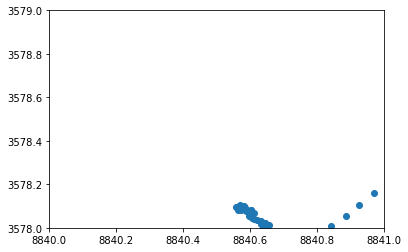

In [27]:
locr,locc = np.where(SurveyIndex==np.max(SurveyIndex))
print(DictoDeph[locr[0],locc[0]])
tx, ty = np.asarray(DictoPos[locr[0],locc[0]])[:,0], np.asarray(DictoPos[locr[0],locc[0]])[:,1]
fig, ax = plt.subplots()
ax.invert_yaxis()
plt.ylim(int(ty[0]), int(ty[0]) + 1)
plt.xlim(int(tx[0]), int(tx[0]) + 1)
ax.scatter(tx, ty)

In [36]:
from shapely import geometry as gom

PixPoints = []
for cx,cy in zip(tx, ty):
    PixPoints.append(gom.Point(cx,cy).buffer(0.2))

In [40]:
print(PixPoints[1])

POLYGON ((8840.772442405858 3578.079976294553, 8840.771479351191 3578.060372866488, 8840.768599461937 3578.04095823015, 8840.763830473004 3578.021919359102, 8840.757218312359 3578.00343960808, 8840.748826658726 3577.985696947188, 8840.738736328318 3577.968862247949, 8840.727044496529 3577.953097637721, 8840.713863762094 3577.938554938316, 8840.69932106269 3577.925374203881, 8840.683556452461 3577.913682372093, 8840.666721753223 3577.903592041684, 8840.64897909233 3577.895200388051, 8840.630499341309 3577.888588227407, 8840.61146047026 3577.883819238473, 8840.592045833922 3577.880939349219, 8840.572442405857 3577.879976294554, 8840.552838977792 3577.880939349219, 8840.533424341455 3577.883819238473, 8840.514385470406 3577.888588227407, 8840.495905719385 3577.895200388051, 8840.478163058491 3577.903592041684, 8840.461328359253 3577.913682372093, 8840.445563749025 3577.925374203881, 8840.431021049621 3577.938554938316, 8840.417840315185 3577.953097637721, 8840.406148483396 3577.9688622479

In [33]:
help(gom.Point)

Help on class Point in module shapely.geometry.point:

class Point(shapely.geometry.base.BaseGeometry)
 |  A zero dimensional feature
 |  
 |  A point has zero length and zero area.
 |  
 |  Attributes
 |  ----------
 |  x, y, z : float
 |      Coordinate values
 |  
 |  Example
 |  -------
 |    >>> p = Point(1.0, -1.0)
 |    >>> print(p)
 |    POINT (1.0000000000000000 -1.0000000000000000)
 |    >>> p.y
 |    -1.0
 |    >>> p.x
 |    1.0
 |  
 |  Method resolution order:
 |      Point
 |      shapely.geometry.base.BaseGeometry
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args)
 |      Parameters
 |      ----------
 |      There are 2 cases:
 |      
 |      1) 1 parameter: this must satisfy the numpy array protocol.
 |      2) 2 or more parameters: x, y, z : float
 |          Easting, northing, and elevation.
 |  
 |  array_interface(self)
 |      Provide the Numpy array protocol.
 |  
 |  svg(self, scale_factor=1.0, fill_color=None)
 |      Returns

In [23]:
np.asarray(DictoDeph[locr[0], locc[0]])

array([ 2.46999979,  2.63999987,  2.50999999,  2.50999999,  2.56999993,
        2.48999977,  2.52999997,  2.6099999 ,  2.48000002,  2.5999999 ,
        2.46000004,  2.51999998,  2.52999997,  2.50999999,  2.51999998,
        2.53999996,  2.52999997,  2.52999997,  2.5       ,  2.54999995,
        2.50999999,  2.48999977,  2.51999998,  2.50999999,  2.48000002,
        2.5       ,  2.5       ,  2.57999992,  2.54999995,  2.57999992,
        2.57999992,  2.56999993,  2.56999993,  2.57999992,  2.57999992,
        2.56999993,  2.57999992,  2.57999992,  2.54999995,  2.5       ,
        2.55999994,  2.52999997], dtype=float32)

## Compute Statistics on pixels containing measurements 

In [ ]:
SurveyValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyVariance = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
for i, j  in Dicto.keys():
    SurveyValues[i, j] = np.mean(Dicto[(i, j)])
    SurveyVariance[i, j] = np.std(Dicto[(i, j)])

## Load Optical Data
### WARNING: Poe special case -> to avoid bigger backup size, data need to be resize at Rasters dimension

In [ ]:
# Load Data at reduce backup size
npzfile = np.load('../../../Poe/CompressedData/SRXData.npz')
Xc = npzfile['Ratios'] # Optical data at croped shape (reduce backup size)
RatiosKeys = npzfile['Keys'] # Keys defining order of recorded ratios 

# Creation of arrays at Raster Size
X = np.full((RasterHeight, RasterWidth, Xc.shape[2]), np.nan) # Final array of optical data at Raster size 
ValidMap = np.full((RasterHeight, RasterWidth), False) # Map of area of Interest -> cropped area reducing backup size

# Translation of the data at the suitable dimension
X[5000:,0:8500,:] = Xc[:,:,:]
ValidMap[5000:,0:8500] = True
del Xc

# Useless here...
ToclassifyIndex = np.logical_and(ValidMap,ClassifIndex)
X.shape

## Special case in Poe, Area of interest for specific calibration manually created

In [ ]:
ShapeFolder = '../../../Poe/Shapes/'
RoiPathName = 'SheratonLagoon.shp'

ResctictedLagoon = mgp.create_mask_from_vector(ShapeFolder + RoiPathName,  RasterHeight, RasterWidth, GT_ds, proj, target_value=1, format=gdal.GDT_Byte)
ResctictedLagoon = ResctictedLagoon.GetRasterBand(1).ReadAsArray().astype(bool)
plt.imshow(ResctictedLagoon)

## Visual check !

In [ ]:
# Manual cropping for better visual rendering
ScatterIndex = np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650]>0)
CroppedDepth = SurveyValues[8800:9400,3500:4650] # Average deph of pixels contained in the visual cropped

# Scatter coordinates and image in rendered dimension
x,y = np.where(ScatterIndex)
Im = ResctictedLagoon[8800:9400,3500:4650]

# Plot
fig, ax = plt.subplots(figsize=(50,50))
plt.imshow(Im)
plt.scatter(y,x,s=80, c='r')
for i in range(len(x)):
    ax.annotate(CroppedDepth[ScatterIndex][i], (y[i]-10,x[i]+10), color='red', size=20)
print("Nombre de pixel comportant une mesure immergées:",len(x))

## Creation of calibration dataset

In [ ]:
assert X.shape[:2]==SurveyValues.shape
ind = ResctictedLagoon * (SurveyIndex>0) # Index of calibration data
Data_x = X[ind,:] # model optical descriptors
Data_y = SurveyValues[ind].reshape(np.sum(ind),) # model target depth

## release memory

In [ ]:
del X

## exploratory statistics

In [ ]:
for i in range(Data_x.shape[1]):
    print(str(RatiosKeys[i]),'correlation : ',np.corrcoef(Data_x[:,i],Data_y)[0,1])
    print("="*10)
mgp.plot_ResRegPlots(Data_x, Data_y, Scale=True, SetTitles=False, Titles=RatiosKeys)

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(20, 8))
for i, ax in enumerate(fig.axes):
    ax.scatter(Data_x[:,i],Data_y, s=4)
    ax.set_title('Band  ' + str(RatiosKeys[i]))
    ax.set_ylabel('Depth')
    ax.set_xlabel('Optical Signal')

In [ ]:
x = Data_x
y = Data_y

In [ ]:
from scipy import stats
used_x = Data_x[:,1].reshape(len(y),)
plt.scatter(used_x,y)
buffer = np.array(stats.linregress(used_x,y)[:])
Interval = np.array([np.min(x),np.max(x)])
plt.plot(Interval, Interval*buffer[0]+buffer[1], c='k')
plt.xlabel('Optical Signal')
plt.ylabel('predicted Depth')


# Huber Regression

In [ ]:
lr = linear_model.RidgeCV(cv=115,fit_intercept=True, alphas= (10 ,0.1))

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = lr.fit(x, y).predict(x)

fig, ax = plt.subplots()
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.scatter(y, predicted, s=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2 : '+str(r2_score(y, predicted)))
plt.show()

In [ ]:
lr.score(x,y)

# Simple Crossvalidated Linear model

In [ ]:
lr = linear_model.LinearRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
#predicted = cross_val_predict(lr, x, y, cv=len(y))
predicted = lr.fit(x, y).predict(x)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2 : '+str(r2_score(y, predicted)))
plt.show()

# Cross Validated RANSAC

In [ ]:
loo = LeaveOneOut()
loo.get_n_splits(x)
predicted = np.full(y.shape,np.nan, np.float)
inlierMat = np.full((y.shape[0], 1, len(y)),np.nan, np.float)
#lr = linear_model.RANSACRegressor(min_samples=0.9, max_trials=100000, residual_threshold=0.4,stop_probability=0.999)
lr = linear_model.RANSACRegressor(min_samples=0.5, residual_threshold=0.2)
counterCheck = 0


for train_index, test_index in loo.split(x):
    lr.fit(x[train_index], y[train_index])
    predicted[test_index] = lr.predict(x[test_index])
    inlierMat[train_index, 0, counterCheck] = lr.inlier_mask_
    counterCheck = counterCheck + 1
    
col = np.nansum(inlierMat, axis=2)
fig, ax = plt.subplots(figsize=(15,15))
im = ax.scatter(y, predicted,c=col, cmap='jet')
plt.colorbar(im)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2 : '+str(r2_score(y, predicted)))
plt.show()

# TheilSenRegressor

In [ ]:
loo = LeaveOneOut()
loo.get_n_splits(x)
predicted = np.full(y.shape,np.nan, np.float)
lr = linear_model.TheilSenRegressor()
counterCheck = 0

for train_index, test_index in loo.split(x):
    lr.fit(x[train_index], y[train_index])
    predicted[test_index] = lr.predict(x[test_index])
    counterCheck = counterCheck + 1
    
fig, ax = plt.subplots()
im = ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# RANSAC Whithout cross validation

In [ ]:
lr = linear_model.RANSACRegressor(min_samples=0.9, max_trials=100000, residual_threshold=0.4,stop_probability=0.999)


# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = lr.fit(x, y).predict(x)

fig, ax = plt.subplots()
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.scatter(y, predicted, c=lr.inlier_mask_, s=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
xIm,yIm = np.where(np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650]>0))
y = SurveyValues[ind].reshape(np.sum(ind),)
plotInd = (col>5).reshape(len(y),)
ind = ResctictedLagoon[8800:9400,3500:4650]
fig = plt.figure(figsize=(50,50))
plt.imshow(ind)
plt.scatter(yIm[plotInd],xIm[plotInd],s=80, c='b')
plt.scatter(yIm[~plotInd],xIm[~plotInd],s=80, c='r')
print("Nombre de point extreme :",np.sum(~plotInd))

In [ ]:
testImage = testImage[8800:9400,3500:4650]**0.4

In [ ]:
xIm,yIm = np.where(np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650]>0))
fig = plt.figure(figsize=(50,50))
plt.imshow(testImage)
plt.scatter(yIm,xIm,s=80, c='r')